In [33]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import tarfile
import urllib

library를 불러왔으니 이제 데이터를 추출해야한다.

이번에 사용하고자 하는 데이터는 캘리포니아의 주택 가격 데이터이다.

데이터의 특성상 labeling이 되어있기 때문에 지도 학습을 진행해야 하며, 사용할 특성이 여러가지이고 구역마다 하나의 정보를 예측한다는 점에서 다중 회귀이자 단변량 회귀이다. 

성분 측정 지표는 예측값과 실제 값의 거리를 이용해 가중치를 갱신하도록 하는 RMSE(평균 제곱근 오차)나 MAE(평균 절대 오차)를 사용하면 될 것으로 판단이 된다.

In [34]:
download_root = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
housing_path = os.path.join('datasets', 'housing')
housing_url = download_root + 'datasets/housing/housing.tgz'

def fetch_housing_data(housing_url = housing_url, housing_path = housing_path):
  os.makedirs(housing_path, exist_ok = True)
  tgz_path = os.path.join(housing_path, 'housing.tgz')
  urllib.request.urlretrieve(housing_url, tgz_path)
  housing_tgz = tarfile.open(tgz_path)
  housing_tgz.extractall(path = housing_path)
  housing_tgz.close()



fetch_housing_data 함수를 이용하게 되면 현재 작업 공간에 datasets/housing 디렉토리를 만들고 housing.tgz 파일을 내려받은 뒤에 압축을 풀어 housing.csv 파일을 만든다. 이렇게 하는 방법은 다른 것 보다도 나중에 계속 데이터가 변화한다고 할 때에 데이터를 새롭게 입력받는 과정을 자동화하여 차후에 편리하도록 해준다.

아래 load_housing_data는 모든 데이터를 담은 판다스의 데이터 프레임 객체를 반환한다.

In [35]:
import pandas as pd

def load_housing_data(housing_path = housing_path):
  csv_path = os.path.join(housing_path, 'housing.csv')
  return pd.read_csv(csv_path)

In [36]:
fetch_housing_data()

housing이 이제부터 데이터 분석에 이용할 데이터셋이다.

In [37]:
housing = load_housing_data()

DataFrame의 head() method를 이용해서 자료를 확인해 본다.

아무 변수도 설정해 주지 않으면 처음 5개의 행을 출력한다.


In [38]:
housing.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


info()를 이용해서 디에터셋의 전체 행 수, 각 특성의 type등이 확인이 가능하다.

In [39]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


info()의 정보를 보면 총 20640개의 데이터가 존재하고, 여기서 total_bedrooms의 개수는 20433개만이 null값이 아니다. 따라서 207개의 구역은 이 특성을 갖고 있지 않음을 의미하는데, 이는 나중에 적절하게 해결이 가능하다. 

ocean_proximity의 필드만 제외하고 모든 특성이 float64로 숫자형인데, 그렇다면 ocean_proximity의 값은 문자열일 것이고 앞서 board()로 출력한 값에 의하면 이는 반복되기 떄문에 범주형 자료임이 확인이 가능하다.

어떤 카테고리가 있고 이 카테고리마다 얼마나 많은 구역이 있는지는 value_counts()메서드로 확인을 한다.

In [40]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

describe()는 숫자형 특성의 요약 정보를 보여준다.

In [41]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


std행은 값이 퍼져있는 정도를 측정하는 표준편차를, 25%,50%,75%는 백분위수를(주어진 백분율이 속하는 하위 부분의 값을 나타냄) 나타낸다.

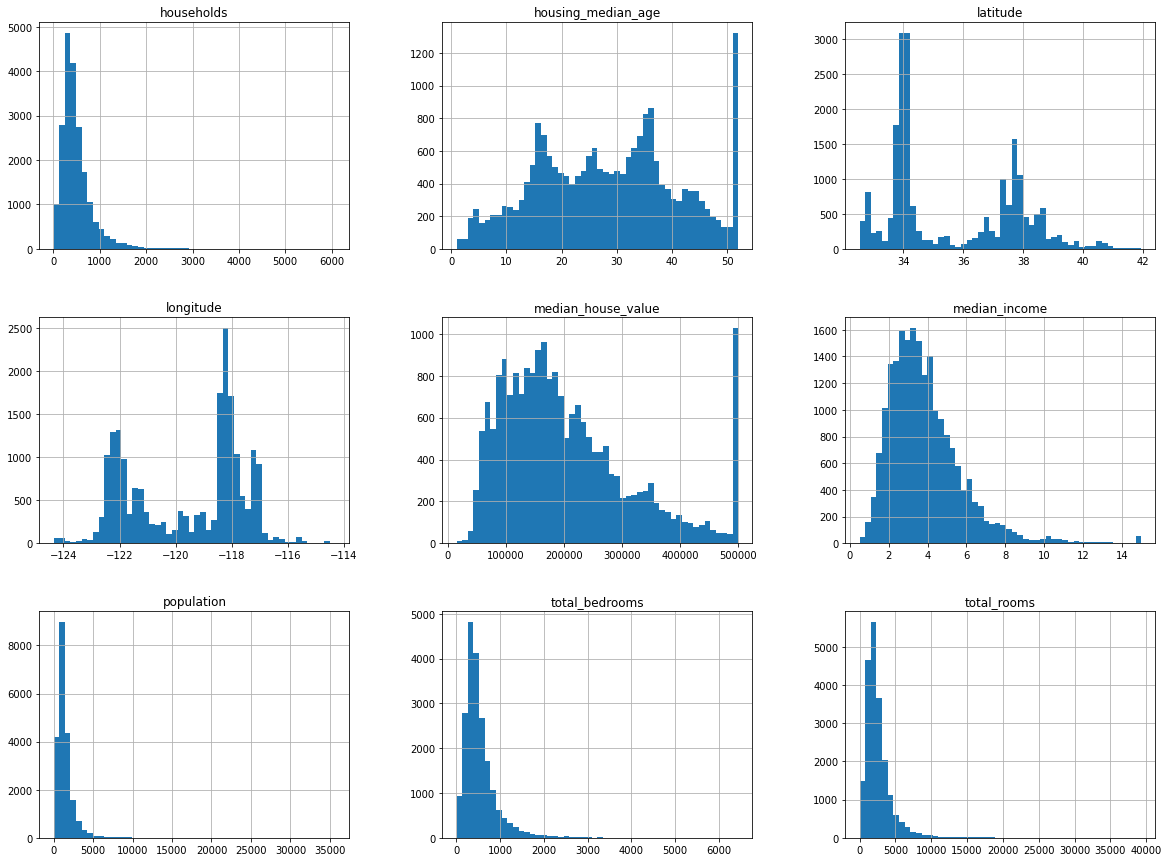

In [42]:
%matplotlib inline
housing.hist(bins = 50, figsize = (20, 15))
plt.show()

중간 주택 가격과 중간 주책 연도가 최댓값과 최솟값을 한정해준 상태인데, 주택 가격 정보가 바로 제일 중요한 데이터 이기 떄문에 이것이 실무에서 치명적이라면


1.  한곗값 밖의 구역에 대한 정확한 label구하기
2.  훈련 세트에서 이런 특성은 제거

많은 히스토그램의 꼬리 부분이 두껍소 오른쪽으로 더 길게 뻗어 있다. 이러한 N(0,1)과 같은 종모양과 거리가 먼경우에는 머신러닝을 통해 규칙을 찾는 것이 조금은 어려울 수 있다. 따라서 나중에 종 모양이 되도록 분포를 변형시키는 과정이 필요하다.



이제 테스트 세트를 만드는 과정이 중요하다.

절대 데이터 분석 전에 미리 테스트 세트의 데이터를 보아서는 안되는데, 이는 미리 예측을 하여 '데이터 스누핑'현상이 발생할 수 있기 때문이다.

In [43]:
import numpy as np

def split_train_test(data, ratio):
  shuffled_indices = np.random.permutation(len(data))
  test_set_size = int(len(data)*ratio)
  test_indices = shuffled_indices[:test_set_size]
  train_indices = shuffled_indices[test_set_size:]
  return data.iloc[train_indices], data.iloc[test_indices]

  

위의 방법은 임의로 비율을 선택하여 테스트 케이스를 생성하는 방법이지만 나중에 데이터셋이 업데이트 되었을 때에 불러오기가 어려울 수 있을 것이다. 따라서 개별 식별자를 생성하여 테스트 케이스의 id를 기준으로 생성하면 된다.

In [44]:
from zlib import crc32
def test_set_check(id, ratio):
  return crc32(np.int64(id) & 0xfffffffff < ratio*2**32)
def split_train_test_by_id(data, ratio, id_column):
  ids = data[id_column]
  in_test_set = ids.apply(lambda id_:test_set_check(id_, ratio))
  return data.loc[~in_test_set], data.loc[in_test_set]



```
housing_with_id = housing.reset_index()
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, 'index')
```
식별자 칼럼이 데이터셋에 따로 없는 경우에는 행의 인덱스를 id로 이용하면 된다. .reset_index()를 하면 'index'열이 추가된 데이터 프레임이 반환된다.



하지만 무엇보다도 이미 주어진 sklearn의 함수를 이용하는 것이 편리하다.

In [45]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size = 0.2, random_state = 42)


train_test_split()함수는 python list, numpy array, pandas dataframe, pandas series등의 객체만을 입력값으로 받을 수 있다.

우리가 주목해야 하는 소득 데이터에 주목해서 그 특징을 더 잘 파악할 수 있도록 새로운 데이테 레이블을 만들어본다.

In [46]:
housing['income_cat'] = pd.cut(housing['median_income'],
                               bins = [0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels = [1,2,3,4,5])
housing.info()
        

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   longitude           20640 non-null  float64 
 1   latitude            20640 non-null  float64 
 2   housing_median_age  20640 non-null  float64 
 3   total_rooms         20640 non-null  float64 
 4   total_bedrooms      20433 non-null  float64 
 5   population          20640 non-null  float64 
 6   households          20640 non-null  float64 
 7   median_income       20640 non-null  float64 
 8   median_house_value  20640 non-null  float64 
 9   ocean_proximity     20640 non-null  object  
 10  income_cat          20640 non-null  category
dtypes: category(1), float64(9), object(1)
memory usage: 1.6+ MB


밑에 새롭게 income_cat라는 column이 생성 되었음을 알 수있다.

In [47]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)
for train_index, test_index in split.split(housing, housing['income_cat']):
  strat_train_set = housing.loc[train_index]
  strat_test_set = housing.loc[test_index]

계층적 샘플링을 시행함으로서 테스트 세트가 전체 인구를 대변하는 데이터가 될 수 있도록 각 계층별로 충분한 샘플 수가 있어야 한다. 즉, train_set와 test_set에서도 일정한 비율을 유지하면서, 즉 일정한 statistic을 유지하면서 sampling을 해야 한다는 의미이다.

.loc을 이용해서 label을 이용해 value의 group을 생성한다.

사실 housing['income_cat']의 데이터만 저장되어 있을 것이라고 생각했는데 그렇지가 않았다. 왜일까??

아무튼 이렇게 해서 housing['income_cat'].value_counts() / len(strat_test_set)를 해주면 정해준 5개의 label별로 비율을 알려준다.

In [48]:
for set_ in (strat_train_set, strat_test_set):
  set_.drop('income_cat', axis = 1, inplace = True)

In [49]:
strat_test_set

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
5241,-118.39,34.12,29.0,6447.0,1012.0,2184.0,960.0,8.2816,500001.0,<1H OCEAN
10970,-117.86,33.77,39.0,4159.0,655.0,1669.0,651.0,4.6111,240300.0,<1H OCEAN
20351,-119.05,34.21,27.0,4357.0,926.0,2110.0,876.0,3.0119,218200.0,<1H OCEAN
6568,-118.15,34.20,52.0,1786.0,306.0,1018.0,322.0,4.1518,182100.0,INLAND
13285,-117.68,34.07,32.0,1775.0,314.0,1067.0,302.0,4.0375,121300.0,INLAND
...,...,...,...,...,...,...,...,...,...,...
20519,-121.53,38.58,33.0,4988.0,1169.0,2414.0,1075.0,1.9728,76400.0,INLAND
17430,-120.44,34.65,30.0,2265.0,512.0,1402.0,471.0,1.9750,134000.0,NEAR OCEAN
4019,-118.49,34.18,31.0,3073.0,674.0,1486.0,684.0,4.8984,311700.0,<1H OCEAN
12107,-117.32,33.99,27.0,5464.0,850.0,2400.0,836.0,4.7110,133500.0,INLAND


set,_drop()을 시행해 주니 strat_train_set 와 strat_test_set의 'income_cat'의 label의 정보가 없어져있다.

In [50]:
housing = strat_train_set.copy()

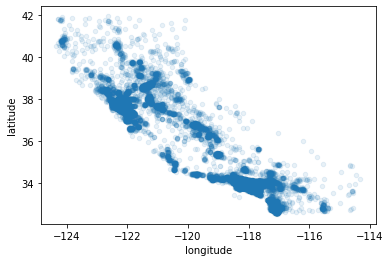

In [51]:
housing.plot(kind = 'scatter', x='longitude', y = 'latitude', alpha = 0.1)

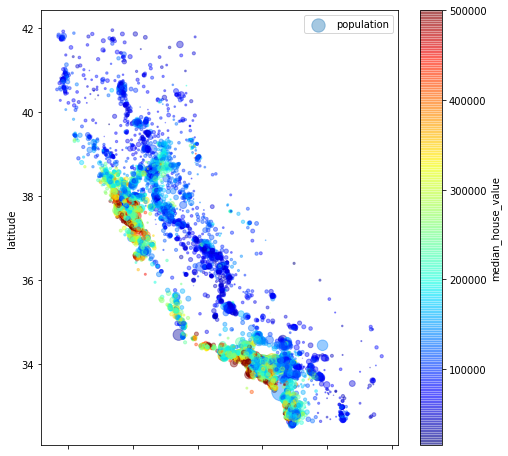

In [52]:
housing.plot(kind = 'scatter', x='longitude', y = 'latitude', alpha = 0.4, s = housing['population']/100, label = 'population', c = 'median_house_value',cmap = plt.get_cmap('jet'),figsize = (8,8))
plt.legend()

컬러 산점도로 시각화한 결과 인구 밀집 지역과 높은 주택 가격을 가지는 곳의 위치가 비교적 일치하는 상황을 알 수 있다.

위와같은 방법으로 두 변수간의 상관계수를 구해주는 것이 매우 중요하다.

In [53]:
housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

우리가 이용해서 예측해야 하는 예측 변수인 'median_house_value'는 없애준다.

In [54]:
housing_labels

17606    286600.0
18632    340600.0
14650    196900.0
3230      46300.0
3555     254500.0
           ...   
6563     240200.0
12053    113000.0
13908     97800.0
11159    225900.0
15775    500001.0
Name: median_house_value, Length: 16512, dtype: float64

housing에는 예측해주어야하는 주택 가격의 정보를 제외했고, housing_labels는 예측의 정답이 저장되어있는 PandasSeries이다.

누락된 데이터를 관리해주는 데이터 정제의 과정이 필요한데,이는


```
housing.dropna(subset = [])을 통해 해당 구역 제거
housing.drop('',axis = 1)을 통해 전체 특성 제거
housing[''].fillna(housing.median(), inplace = True)를 통해 빈자리를 중앙값으로 대체
```
의 3가지 방법이 존재하고, 뿐만 아니라 sklearn.impute의 SimpleImputer을 이용해도 된다.



In [55]:
housing.drop('total_bedrooms', axis = 1)

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,710.0,339.0,2.7042,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,306.0,113.0,6.4214,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,936.0,462.0,2.8621,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,1460.0,353.0,1.8839,INLAND
3555,-118.59,34.23,17.0,6592.0,4459.0,1463.0,3.0347,<1H OCEAN
...,...,...,...,...,...,...,...,...
6563,-118.13,34.20,46.0,1271.0,573.0,210.0,4.9312,INLAND
12053,-117.56,33.88,40.0,1196.0,1052.0,258.0,2.0682,INLAND
13908,-116.40,34.09,9.0,4855.0,2098.0,765.0,3.2723,INLAND
11159,-118.01,33.82,31.0,1960.0,1356.0,356.0,4.0625,<1H OCEAN


아래 두가지는 sklearn의 문자형 데이터를 숫자형 데이터로 바꾸어 주는 방법이다.

In [56]:
from sklearn.preprocessing import OrdinalEncoder
housing_cat = housing[['ocean_proximity']]
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

In [57]:
from sklearn.preprocessing import LabelEncoder
housing_cat = housing[['ocean_proximity']]
label_encoder = LabelEncoder()
housing_cat_1encoded = label_encoder.fit_transform(housing_cat)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [58]:
housing_cat_encoded

array([[0.],
       [0.],
       [4.],
       ...,
       [1.],
       [0.],
       [3.]])

In [59]:
from tensorflow.keras.utils import to_categorical
categorical = to_categorical(housing_cat_encoded)
categorical

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]], dtype=float32)

one-hot-encoding을 진행 할 수 있는 모듈에는 대표적으로 2가지가 존재하는데, 바로


```
tensorflow.keras.utils의 to_categorical
sklearn.preprocessing의 OneHotEncoder이다.
```
둘이 사용법이 조금 다른데, to_categorical은 숫자로 변형된 자료만 변형시키고, OneHotEncoder은 그냥 처음부터 변형이 가능하다.



In [60]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot = housing_cat_1hot.toarray()
housing_cat_1hot

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

PipeLine 만들기

In [61]:
from sklearn.base import BaseEstimator, TransformerMixin
rooms_idx, bedrooms_idx, population_idx, households_idx = 3,4,5,6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
  def __init__(self, add_bedrooms_per_room = True):   #bedrooms_per_room의 값이 *args나 **kargs가 아니다.
    self.add_bedrooms_per_room = add_bedrooms_per_room
  def fit(self,x,y=None):
    return self
  def transform(self, x):
    rooms_per_household = x[:, rooms_idx] / x[:, households_idx]
    population_per_household = x[:, population_idx] / x[:, households_idx]
    if self.add_bedrooms_per_room:
      bedrooms_per_room = x[:, bedrooms_idx] / x[:, rooms_idx]
      return np.c_[x, rooms_per_household, population_per_household, bedrooms_per_room]
    else:
      return np.c_[x,rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room = False)
housing_extra_attribs = attr_adder.transform(housing.values)
    

위와 같이 python class를 이용해서 데이터 준비 단계를 자동화한다면 하이퍼파라미터를 최적의 상태로 변경/설정하는데 효과적일 것이다

위의 코드는 사실상 이해가 잘안되는 부분도 있는데, class이용 방법을 제대로 다시 공부해 봐야 할것 같다.

In [62]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy = 'median')
housing_num = housing.drop('ocean_proximity', axis = 1)
imputer.fit(housing_num)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

In [63]:
housing_num

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347
...,...,...,...,...,...,...,...,...
6563,-118.13,34.20,46.0,1271.0,236.0,573.0,210.0,4.9312
12053,-117.56,33.88,40.0,1196.0,294.0,1052.0,258.0,2.0682
13908,-116.40,34.09,9.0,4855.0,872.0,2098.0,765.0,3.2723
11159,-118.01,33.82,31.0,1960.0,380.0,1356.0,356.0,4.0625


모든 변환단계들을 순서대로 실행할 수 있도록 해주는 sklearn에 저장되어있는 pipeline을 만들어준다.

이후에는 하나의 변환기로 각 열마다 적절한 변환을 적용하여 모든 열을 처리할 수 있도록 ColumnTransformer을 이용한다.

특성 스케일링 (Feature Scaling)

In [64]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
                         ('imputer', SimpleImputer(strategy = 'median')),
                         ('attribs_adder', CombinedAttributesAdder()),
                         ('std_scaler', StandardScaler()),
])

housing_num_tr = num_pipeline.fit_transform(housing_num)
housing_num_tr

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

위에서 구한 housing_num이라는 자료는 범주형 자료를 제외한 숫자형 자료만을 담고 있는 것이다. 그리고 num_pipeline은 숫자형 자료만을 scaling할 수 있는 pipeline이다. 

따라서 범주형 열과 수치형열을 모두 동시에처리할 수 있는 pipeline을 만들면 좋을텐데, 여기서 ColumnTRansfer을 이영해 모든 열을 처리할 수있게 해준다. OneHotEncoder은 희소 행렬을 반환하고 num_pipeline은 밀집행렬(numpy array)로 반환하기 때문에 ColumnTransfer이 최종 행렬의 밀집 정도를 추정해서 밀집도와 임계값의 크기 대소에 따라 밀집 행렬을 반환할지 희소행렬을 반환할지 결정한다.

In [65]:
from sklearn.compose import ColumnTransformer
num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']
full_pipeline = ColumnTransformer([
                                ('num', num_pipeline, num_attribs),
                                ('cat', OneHotEncoder(), cat_attribs),
])
housing_prepared = full_pipeline.fit_transform(housing)

모델 선택과 훈련

앞서서 데이터셋의 설정과 변형을 제대로 했다면 오히려 훈련시키는 과정이 더 간편할 수 있다.

따라서 그냥


```
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)   #(x_train, y_train)이다
```


```
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
```

위와 같이 이미 주어진 모델로 선형 회귀가 충분히 가능하지만 당연하게도 정확도가 놏거나 오차가 만족스럽게 적을수는 없다.(rmse는 mse(평균 제곱 오차)에 제곱근을 씌운 형태)

cf. 이 데이터에 DeceisionTreeRegressor이라는 결정 트리의 한 종류인 모델을 적용하면 데이터에서 복잡한 비선형 구조를 찾을 수가 있는데, 막상 loss를 구해보면 0이 나온다. 이는 이 강력한 모델이 과대적합을 했음을 의미한다. 이렇게까지 모델이 성늘이 좋을 필요가 없는 데이터라는 뜻이다.





교차 검증을 이용한 평가

결정트리 모델을 평가하는 방법으로는 train_test_split함수를 이용해서 훈련세트를 저 훈련세트와 검증 세트로 나누어서 평가하는 방법이 있고, sklearn의 k-fold-cross-validation을 이용해서 훈련세트를 fold라는 subset으로 분리해서 k번 학습시키는 것이다.

또한 RandomForestRegressor모델을 이용해서 구할 수 있는데, randomforest는 특성을 무작위로 선택새허 많은 결정 트리를 만들고 그 예측을 평균내는 방법을 사영한다. 여러 다른 모델을 모아서 하나의 모델을 만드는 것을 '앙상블 학습'이라고 하는데, 이는 머신러닝 알고리즘의 성능을 극대화하는 대표적인 방법이다.

In [66]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

param_grid = [
              {'n_estimators' : [3,10,30],'max_features' : [2,4,6,8]},
              {'bootstrap' : [False], 'n_estimators' : [3,10], 'max_features' : [2,3,4]},
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv = 5, scoring = 'neg_mean_squared_error', return_train_score = True)

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

모델을 어느정도 가능성 있어보이는 것으로 설정항 뒤에 모델들을 세부튜닝해야 하는데 사실 제일 단순한 방법은 적절한 것을 찾을 때까지 수동으로 하이퍼파라미터값을 조정하는 것이다.

그러나 그렇게 하기보다 sklearn의 GridSearchCV를 이용해도 된다. 이는 가능한 모든 하이퍼파라미터 조합에 대해 교차검증을 하는데, 따라서 최적의 하이퍼파라미터값을 찾게 된다.



In [68]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [69]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=8, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [71]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
  print(np.sqrt(-mean_score), params)

64454.845320300956 {'max_features': 2, 'n_estimators': 3}
55309.9235459275 {'max_features': 2, 'n_estimators': 10}
52540.43819411255 {'max_features': 2, 'n_estimators': 30}
60670.35852133199 {'max_features': 4, 'n_estimators': 3}
52364.55934342153 {'max_features': 4, 'n_estimators': 10}
50417.776116707995 {'max_features': 4, 'n_estimators': 30}
59175.54128636077 {'max_features': 6, 'n_estimators': 3}
52275.10597378694 {'max_features': 6, 'n_estimators': 10}
49936.37805033548 {'max_features': 6, 'n_estimators': 30}
58482.12531824447 {'max_features': 8, 'n_estimators': 3}
52729.558007507374 {'max_features': 8, 'n_estimators': 10}
49917.85701576124 {'max_features': 8, 'n_estimators': 30}
62610.04377785398 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54162.52412278336 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59498.49790104644 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52555.38943650301 {'bootstrap': False, 'max_features': 3, 'n_estimators': 

이로써 점수가 제일 낮은(오류의 점수, 즉 RMSE값은 낮을수록 좋다) max_features = 8이고 n_estimators = 30인 경우가 최적의 경우의 하이퍼파라미터임을 알 수 있다.



이 밖에도 모델 세부 튜닝을 할 수 있는 방법은 다양하다.



1. 랜덤 탐색(RandomizedSearchCV)
2. 앙상블 방법(다양한 최적의 모델들을 연결해보는 방법)
3. 최상의 모델과오파 분석(RandomForestRegressor)
4. 테스트 세트로 시스템 평가하기

아래 코드로 4번을 실행할 예정이다



In [73]:
from sklearn.metrics import mean_squared_error
final_model = grid_search.best_estimator_

x_test, y_test = strat_test_set.drop('median_house_value', axis = 1), strat_test_set['median_house_value'].copy()

x_test_prepared = full_pipeline.transform(x_test)

final_predictions = final_model.predict(x_test_prepared)

final_mse = np.sqrt(mean_squared_error(y_test, final_predictions))

In [74]:
final_mse

48010.80842153082

일반화 오차의 95%의 신뢰도 구해보기

In [76]:
from scipy import stats
confidence = 0.95
squared_errors = ((final_predictions)-y_test) **2
np.sqrt(stats.t.interval(confidence, len(squared_errors)-1, loc = squared_errors.mean(), scale = stats.sem(squared_errors)))


array([46041.53605096, 49902.42888523])

위의 array가 신뢰도 95%에서의 신뢰구간이다.